Submit a Jupyter notebook named `modeling.ipynb` containing:
1. Clear markdown cells explaining your approach
2. Well-commented code cells showing your analysis
3. Visualizations of results where appropriate
4. Interpretations of your findings

### Time Series Tasks

1. Convert the longitudinal blood pressure measurements into a proper time series:
   - Create a pandas Series with DatetimeIndex using `visit_date`
   - Handle any missing or duplicate measurements appropriately
   - Tips: 
     - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
     - Handle duplicates with `duplicated()` and appropriate aggregation
     - Consider timezone handling with `tz_localize()` if needed
     - Use `interpolate()` or `fillna()` for missing values

In [9]:
import pandas as pd

In [10]:
long_data = pd.read_csv('patient_longitudinal.csv', sep='\t') # notation: separation by tab, not comma
long_data['visit_date'] = pd.to_datetime(long_data['visit_date'], format='%Y-%m-%d') # edit date time

In [11]:
long_data = long_data.drop_duplicates(subset=['patient_id', 'visit_date']) # remove duplicates
long_data = long_data.fillna(method='ffill') # ffill is forward fill 

C:\Users\jelou\AppData\Local\Temp\ipykernel_13740\2532326965.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  long_data = long_data.fillna(method='ffill') # ffill is forward fill


2. Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations
   - Visualize both the original and smoothed trends
   - Tips:
     - Use `resample('ME').mean()` for month-end frequency
     - Add `min_periods` to `rolling()` to handle edge cases
     - Consider `interpolate()` method for gaps
     - Use `ewm()` for exponential weighted alternatives

In [ ]:
long_data.set_index('visit_date', inplace=True) # setting index using visit_date
monthly_data = long_data.resample('M').mean() # resampling for month
monthly_data = monthly_data.interpolate(method='linear') # using interpolate for gaps using linear fills

C:\Users\jelou\AppData\Local\Temp\ipykernel_13740\4102786578.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = long_data.resample('M').mean() # resampling


In [13]:
monthly_data_2 = long_data.groupby('patient_id').resample('M', level='visit_date').mean()

C:\Users\jelou\AppData\Local\Temp\ipykernel_13740\3562633025.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data_2 = long_data.groupby('patient_id').resample('M', level='visit_date').mean()


In [14]:
import matplotlib.pyplot as plt

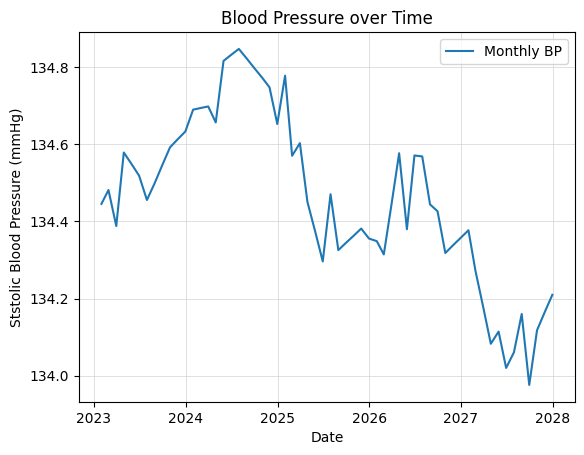

In [28]:
plt.figure()
plt.plot(monthly_data['bp_systolic'], label='Monthly BP')
plt.title('Blood Pressure over Time')
plt.ylabel('Ststolic Blood Pressure (mmHg)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.show()

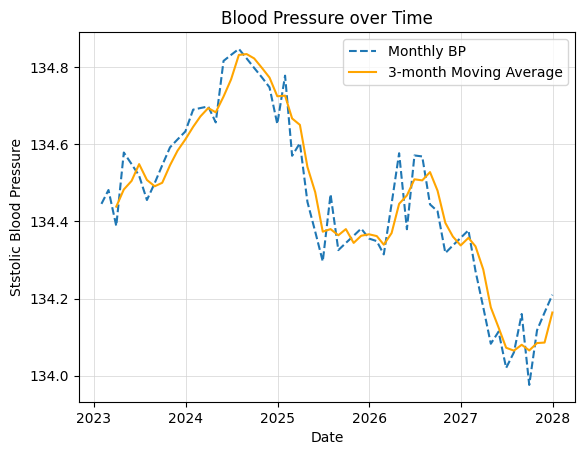

In [29]:
plt.figure()
plt.plot(monthly_data['bp_systolic'], label='Monthly BP', linestyle='--')
plt.plot(monthly_data['bp_systolic'].rolling(window=3).mean(), label='3-month Moving Average', color='orange')
plt.title('Blood Pressure over Time')
plt.ylabel('Ststolic Blood Pressure')
plt.xlabel('Date')
plt.legend()
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.show()

### Statistical Modeling Tasks

1. Analyze factors affecting baseline blood pressure:
   - Use statsmodels OLS to predict `bp_systolic`
   - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
   - Interpret the coefficients and their p-values
   - Assess model fit using R-squared and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
     - Use `sm.OLS(y, X).fit()` to fit the model
     - Use `summary()` to examine p-values and confidence intervals
     - Plot residuals vs fitted values and Q-Q plot
     - Consider robust standard errors with `HC3` covariance type

In [20]:
import statsmodels.api as sm

In [21]:

baseline_data = pd.read_csv('patient_baseline.csv', sep='\t') # read baseline_data

X = baseline_data[['age', 'bmi', 'smoking', 'diabetes']] # predictors
X = sm.add_constant(X)  # constant
y = baseline_data['bp_systolic'] # predict bp_systolic

model = sm.OLS(y, X).fit() # sm.OLS model

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     150.2
Date:                Thu, 05 Dec 2024   Prob (F-statistic):          1.65e-100
Time:                        15:28:32   Log-Likelihood:                -3700.7
No. Observations:                1000   AIC:                             7411.
Df Residuals:                     995   BIC:                             7436.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.0

**Coefficients:**
1. const = 108.4929: representing the expected intercept of bp_systolic if all factors (age, bmi, smoking, diabetes) are 0. 
2. age = 0.2840: bp_systolic increases approximately 0.28 per unit increase of age (assuming other variables constant). 
3. bmi = 0.2786: bp_systolic increases approx. 0.28 per unit increase of BMI (assuming other variables constant). 
4. smoking = 5.2412: individuals who smoke have a level of bp_systolic that is 5.24 mmHg higher than those who do not smoke (assuming other variables constant). Suggestive of strong association between smoking and systolic blood pressure. 
5. diabetes = 9.8732: individuals who have diabetes have a level of bp_systolic that is 9.87 mmHg higher than those who do not have diabetes (assuming other variables constant). Suggestive of strong association between diabetes and systolic blood pressure. 

**P-values:**
1. const p-value = 0.000: under 0.05, highly significant
2. age p-value = 0.000: under 0.05, highly significant
3. bmi p-value = 0.000: under 0.05, highly significant
4. smoking p-value = 0.000: under 0.05, highly significant
5. diabetes p-value = 0.000: under 0.05, highly significant

**Model fit:**
1. R-squared = 0.376: moderate, however it implies there are other factors not included that might affect bp_systolic. 
2. Adjusted R-squared = 0.374: even after adjustment with the other predictors, it is still close to the R-squared and did not improve the model significantly. 
3. F-statistic = 150.2: the high value indicates that at least one predictor does significantly influence bp_systolic. 


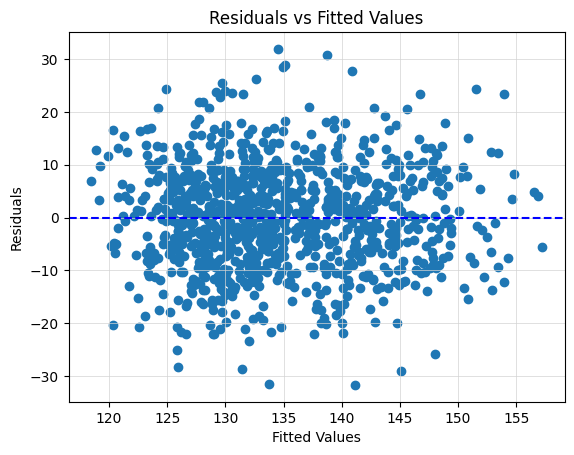

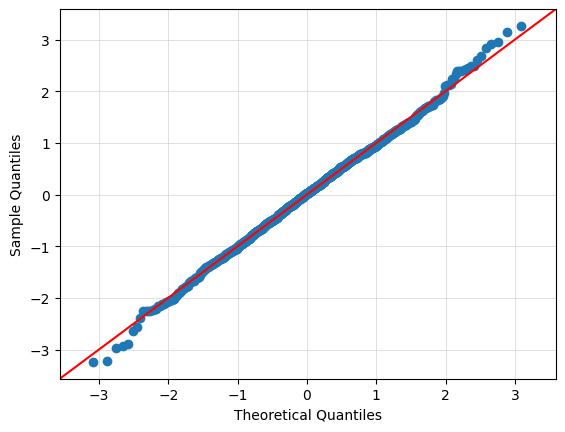

In [31]:
plt.figure() # Plot residuals vs fitted values
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='blue', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.show()

sm.qqplot(model.resid, line='45', fit= 'True') # Q-Q plot
plt.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray')
plt.show()

2. Model treatment effectiveness:
   - Fit a GLM with binomial family to predict treatment success
   - Use baseline characteristics and `adherence` as predictors
   - Report odds ratios and their confidence intervals
   - Assess model fit using deviance and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term
     - Use `sm.GLM(y, X, family=sm.families.Binomial()).fit()`
     - Get odds ratios with `np.exp(params)`
     - Check residual deviance vs null deviance
     - Use `influence()` to detect influential observations

In [ ]:
treatment_data = pd.read_csv('patient_treatment.csv', sep='\t') # load data

X_treatment = treatment_data[['age', 'bmi', 'smoking', 'diabetes', 'adherence']] # set baseline characteristics and adherence as predictors
X_treatment = sm.add_constant(X_treatment) # add constant
y_treatment = treatment_data['outcome'] # set outcome as treatment result

model = sm.GLM(y_treatment, X_treatment, family=sm.families.Binomial()).fit() # use sm.GLM

print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      994
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -656.42
Date:                Thu, 05 Dec 2024   Deviance:                       1312.8
Time:                        15:57:25   Pearson chi2:                 1.00e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01896
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2681      0.691     -1.836      0.0

In [33]:
import numpy as np

In [37]:
odds_ratios = np.exp(model.params)
print(odds_ratios)

CI = np.exp(model.conf_int())
print(CI)

const       1.311804e+47
age         1.328451e+00
bmi         1.321228e+00
smoking     1.888963e+02
diabetes    1.940371e+04
dtype: float64
                     0             1
const     2.591551e+45  6.640152e+48
age       1.270749e+00  1.388773e+00
bmi       1.159927e+00  1.504961e+00
smoking   4.804309e+01  7.427039e+02
diabetes  4.524332e+03  8.321761e+04


### Machine Learning Tasks (stretch goal)

1. Build a prediction pipeline:
   - Create features from baseline characteristics
   - Standardize numeric features using `StandardScaler`
   - Train a logistic regression model to predict treatment outcomes
   - Include regularization to prevent overfitting
   - Tips:
     ```python
     from sklearn.pipeline import make_pipeline
     from sklearn.preprocessing import StandardScaler
     from sklearn.linear_model import LogisticRegression
     
     # Create pipeline with specific components
     pipeline = make_pipeline(
         StandardScaler(),
         LogisticRegression(
             penalty='l2',
             solver='lbfgs',
             max_iter=1000,
             class_weight='balanced'
         )
     )
     ```
     - Use `ColumnTransformer` for mixed numeric/categorical features
     - Consider `SelectKBest` or `RFE` for feature selection
     - Try different regularization strengths with `C` parameter
     - Use `Pipeline` to prevent data leakage

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest

In [40]:
pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=1000,
        class_weight='balanced'
    )
)

x_data = treatment_data[['age', 'bmi', 'smoking', 'diabetes', 'adherence']] # set predictors
y_data = treatment_data['outcome']

pipeline.fit(x_data, y_data)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

2. Validate model performance:
   - Split data into 70% training and 30% test sets
   - Implement 5-fold cross-validation on the training set
   - Report accuracy, precision, recall, and ROC AUC
   - Generate confusion matrix and ROC curve
   - Tips:
     ```python
     from sklearn.model_selection import (
         train_test_split, 
         StratifiedKFold,
         cross_validate
     )
     from sklearn.metrics import (
         classification_report,
         RocCurveDisplay,
         confusion_matrix
     )
     
     # Stratified split for imbalanced data
     X_train, X_test, y_train, y_test = train_test_split(
         X, y, 
         test_size=0.3, 
         stratify=y,
         random_state=42
     )
     
     # Cross-validation with multiple metrics
     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
     scores = cross_validate(
         pipeline,
         X_train, y_train,
         cv=cv,
         scoring=['accuracy', 'precision', 'recall', 'roc_auc']
     )
     ```
     - Use `StratifiedKFold` for imbalanced datasets
     - Consider precision-recall curve for imbalanced data
     - Plot learning curves to diagnose bias/variance
     - Use `cross_validate` for multiple metrics at once

In [ ]:
# Split data into train and test 
X_train, X_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.3, 
    stratify=y_data, random_state=42
)

# Set up data splitting numeric and catagorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 
         make_pipeline(
             SimpleImputer(strategy='mean'),  # impute values with mean
             StandardScaler()  # Standardize numeric features
         ), 
         ['age', 'bmi', 'adherence']),  # numeric features
        ('cat', 
         make_pipeline(
             SimpleImputer(strategy='most_frequent'),  # impute values with 'mean'
             OneHotEncoder(handle_unknown='ignore')  # OneHotEncode categorical features
         ), 
         ['smoking', 'diabetes'])  # categorical features
    ]
)

# Apply new pipeline
pipeline = make_pipeline(
    preprocessor,  # use processed data
    StandardScaler(),  
    LogisticRegression(
        penalty='l2',  
        solver='lbfgs', 
        max_iter=1000, 
        class_weight='balanced'  
    )
)

# Cross-validation with multiple metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc']
)

print("Cross-validation scores:", scores)

Cross-validation scores: {'fit_time': array([0.01559138, 0.00899839, 0.00800014, 0.00837398, 0.00943804]), 'score_time': array([0.01549435, 0.00899982, 0.00932598, 0.00844789, 0.00946188]), 'test_accuracy': array([0.55      , 0.57857143, 0.5       , 0.51428571, 0.56428571]), 'test_precision': array([0.43243243, 0.46666667, 0.3974359 , 0.40540541, 0.44776119]), 'test_recall': array([0.60377358, 0.64814815, 0.57407407, 0.55555556, 0.55555556]), 'test_roc_auc': array([0.58100195, 0.56481481, 0.53617571, 0.49677003, 0.55641688])}
[[99 86]
 [55 60]]
              precision    recall  f1-score   support

           0       0.64      0.54      0.58       185
           1       0.41      0.52      0.46       115

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.52       300
weighted avg       0.55      0.53      0.54       300



In [47]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[99 86]
 [55 60]]


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.54      0.58       185
           1       0.41      0.52      0.46       115

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.52       300
weighted avg       0.55      0.53      0.54       300

